## Data Analysis Interview Challenge

### Part 1 ‐ Exploratory data analysis

This exercise provides a dataset which contains (simulated) timestamps of user logins in a particular geographic location. It is required to find patterns in the dataset.

In [90]:
# Import modules
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
# read JSON file and save as dataframe
data_df = pd.read_json('logins.json')

In [92]:
# check first few rows
data_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [93]:
# check column data type
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


Column 'login_time' is object (categorical) type. Should be converted to datetime

In [94]:
# change column 'login_time' to datetime
data_df['login_time']= pd.to_datetime(data_df['login_time'])

In [95]:
# check the new column type
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


Column 'login_time' has been changed to datetime.

In [96]:
# check missing values
data_df.isnull().sum()

login_time    0
dtype: int64

No missing values are found in the dataset.

In [97]:
# let's count the login time in quarter-hour.
hour_count = defaultdict(int)
for value in data_df['login_time']:
    m = value.minute
    h = value.hour
    if m<=15: m_r = 0
    elif m<=30: m_r = 1
    elif m<=45: m_r = 2
    else: m_r = 3 
    i = h*4 + m_r
    hour_count[i] += 1

In [98]:
# create a dataframe for the hour counting results. time_index represents the hour in a day.
hour_count_df = pd.DataFrame(list(hour_count.items()), columns=['time_index', 'count'])

In [99]:
# sort the dataframe on the value of 'time_index'
hour_count_df.sort_values('time_index', ascending=True, inplace=True)

In [100]:
# convert the 'time_index' to hour with decimals
hour_count_df['hour'] = hour_count_df['time_index']*0.25

In [101]:
hour_count_df.head()

,time_index,count,hour
15,0,1547,0.00
16,1,1533,0.25
17,2,1508,0.50
18,3,1405,0.75
19,4,1662,1.00


Text(0, 0.5, 'Counts on login')

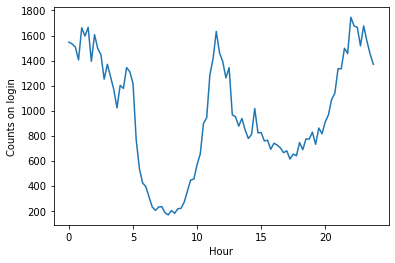

In [102]:
# plot the count vs hour
plt.plot(hour_count_df['hour'], hour_count_df['count'])
plt.xlabel('Hour')
plt.ylabel('Counts on login')

#### The plot above shows the daily cycle very clearly. The least login was during 6-8 am, and the peak login was between 11am-1pm, and 10pm-3am. 

#### Let's then see the pattern in a weekly basis.

In [103]:
# count on week days
weekday_count = defaultdict(int)
for value in data_df['login_time']:
    weekday_count[value.weekday()] += 1

In [104]:
weekday_count

defaultdict(int,
            {3: 11960,
             4: 15208,
             5: 19377,
             6: 18167,
             0: 8823,
             1: 9268,
             2: 10339})

In [105]:
# create dataframe for the weekday count
weekday_count_df = pd.DataFrame(list(weekday_count.items()), columns=['weekday_num', 'count'])

In [106]:
# sort the dataframe
weekday_count_df.sort_values('weekday_num', inplace=True)

In [107]:
# convert the weekday number to week days. As predefined, 0 = Monday and 6 = Sunday 
weekday_count_df['weekday'] = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [108]:
weekday_count_df

,weekday_num,count,weekday
4,0,8823,Monday
5,1,9268,Tuesday
6,2,10339,Wednesday
0,3,11960,Thursday
1,4,15208,Friday
2,5,19377,Saturday
3,6,18167,Sunday


Text(0, 0.5, 'Counts on login')

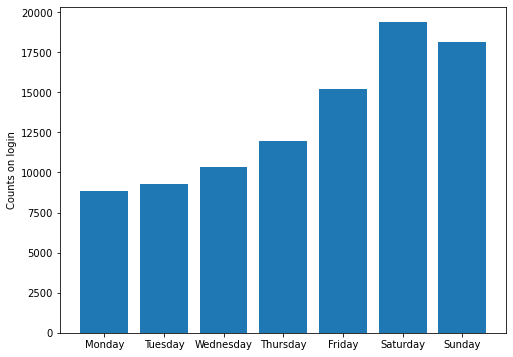

In [109]:
# plot the weekday login count
plt.figure(figsize=(8,6))
plt.bar(weekday_count_df['weekday'], weekday_count_df['count'])
plt.ylabel('Counts on login')

#### The patten in a weekly cycle is that more logins happen on weekend than on week days. 

### Part 2 ‐  Experiment and metrics design

*** From work instruction ***
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

#### A： The key measure of success should be the traffic flow. If reimbursing toll cost does encourage the driver partners to travel between the two cities, it is expected to see a traffic flow increase from Metropolis to Gotham at weekday nights, and from Gotham to Metropolis during daytime at week days. The reason is that if this method does increases travels, we should see clear traffic increase after starting to reimburse toll cost.

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a) how you will implement the experiment
b) what statistical test(s) you will conduct to verify the significance of the observation
c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

#### A: 
a) how you will implement the experiment?
A: There should be a few steps in the experiment:
step 1: Count the daily traffic flow when there is the toll charged;
step 2: Claim to the public that there will be no toll charged in a certain period of time, maybe two weeks or one month;
step 3: Count the daily traffic flow when there is no toll charged;
step 4: Do the hypothesis test to calculate the p value;
step 5: Depending on the p value, claim the final result.

b) what statistical test(s) you will conduct to verify the significance of the observation
A: hypothesis test. Steps for this test should be:
step 1: state the null hypothesis, which is that the reimbursing toll does not help to increase traffic volume;
step 2: calculate the p value;
step 3: If the p value is smaller than 0.05, we will reject the null hypothesis, which is that reimbursing toll does not help increase traffic. 

c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.
A: Explain to the city operation teams that the result from the experiment support or reject the effect of reimbursing toll. Based on the traffic amount with no toll reimbursing, you can also calculate the financial loss when the toll is not charged.  

### Part 3 ‐   Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

#### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

Let's first read the data as dataframe.

In [110]:
# Read JSON file
df = pd.read_json('ultimate_data_challenge.json')

In [111]:
# check first few rows
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [112]:
# check missing values
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

Column 'avg_rating_of_driver', 'phone', and 'avg_rating_by_driver' have missing values. Since there are many missing values in 'avg_rating_of_driver', we will fill it with mean value. For 'phone' and 'avg_rating_by_driver', since missing values are just a small amount, we will just drop rows with missing values.

In [113]:
# check features of column "avg_rating_of_driver"
df['avg_rating_of_driver'].describe()

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

the minimum value of column 'avg_rating_of_driver' is 1.0 and the max is 5.0. So it is safe to fill missing value with mean. If there are quite a few outliners, we will fill with median to avoid bias. We can also see that the mean value is 4.6. We will use this value to fill in missing values.

In [114]:
# fill missing values with mean
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(4.6)

In [115]:
# drop missing values
df = df.dropna()

In [116]:
# check if there is still missing values
df.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [117]:
# check the new data size
df.shape

(49406, 12)

Let's then plot histogram on numerical columns in the data frame.

In [118]:
def histplots(columns, ncol=None, figsize=(19, 20)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.4, hspace=0.3)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.hist(df[col])
        ax.set(xlabel=col, ylabel='count')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [119]:
columns_numerical = df.select_dtypes(['float','int64']).columns

In [120]:
columns_numerical

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver'],
      dtype='object')

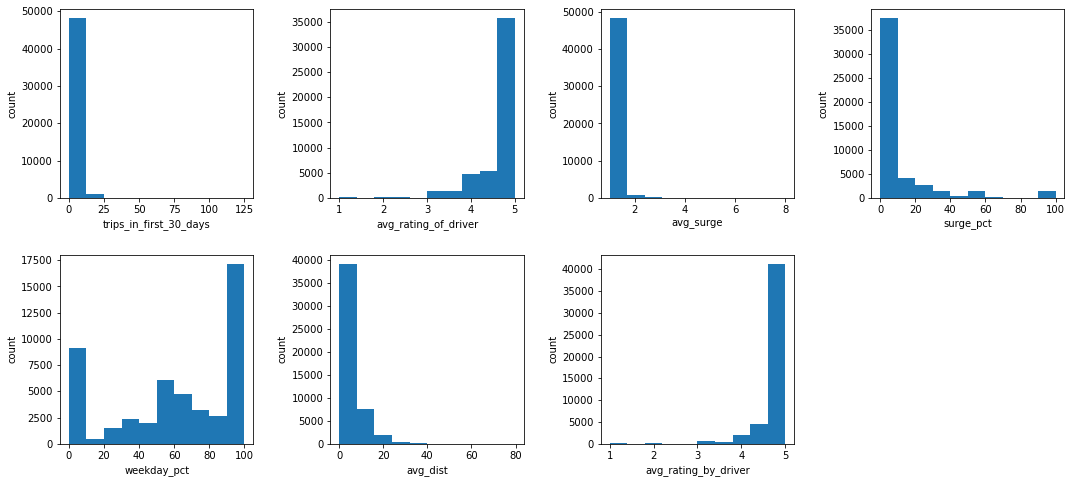

In [121]:
histplots(columns_numerical, 4, (18,8))

They all looks fine so we will leave them there.

Let's check the column type.

In [122]:
# check the column type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49406 non-null  object 
 1   trips_in_first_30_days  49406 non-null  int64  
 2   signup_date             49406 non-null  object 
 3   avg_rating_of_driver    49406 non-null  float64
 4   avg_surge               49406 non-null  float64
 5   last_trip_date          49406 non-null  object 
 6   phone                   49406 non-null  object 
 7   surge_pct               49406 non-null  float64
 8   ultimate_black_user     49406 non-null  bool   
 9   weekday_pct             49406 non-null  float64
 10  avg_dist                49406 non-null  float64
 11  avg_rating_by_driver    49406 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


We can see that the types of column "signup_date" and "last_trip_date" are all "object", which means categorical. So let's change it to datetime.

In [123]:
# change 'signup_date' to datetime
df['signup_date']= pd.to_datetime(df['signup_date'])

In [124]:
# change 'last_trip_date' to datetime
df['last_trip_date']= pd.to_datetime(df['last_trip_date'])

In [125]:
# check the new column type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49406 non-null  object        
 1   trips_in_first_30_days  49406 non-null  int64         
 2   signup_date             49406 non-null  datetime64[ns]
 3   avg_rating_of_driver    49406 non-null  float64       
 4   avg_surge               49406 non-null  float64       
 5   last_trip_date          49406 non-null  datetime64[ns]
 6   phone                   49406 non-null  object        
 7   surge_pct               49406 non-null  float64       
 8   ultimate_black_user     49406 non-null  bool          
 9   weekday_pct             49406 non-null  float64       
 10  avg_dist                49406 non-null  float64       
 11  avg_rating_by_driver    49406 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

Next, we would like to check if a user is retained or not. The criteria is that if the last trip date is within 30 days from now. 

Let's first "assume" what the current date is. We will just assume that it is the latest day in the column "last_trip_date".

In [126]:
# Find current date
current_date = df['last_trip_date'].max()

In [127]:
# print current date
current_date

Timestamp('2014-07-01 00:00:00')

In [128]:
# define a new column "retained", whose value is true if the last trip date is within 30 days
df['retained'] = (current_date - df['last_trip_date']) < timedelta(days=30)

In [129]:
# count the sum of retained users
sum(df['retained'])

18146

In [130]:
retained_ratio = sum(df['retained'])/df.shape[0]

In [131]:
retained_ratio

0.36728332591183255

We can see the retained ratio is about 36.7%.

#### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

This should be a problem of classification. According to my experience, Random Forest is a good model for classification prediction.

First we need to create the target column, which is "activate_in_6th_month".

In [132]:
df['active_in_6th_month'] = (df['last_trip_date']-df['signup_date'])>timedelta(days=150)

In [133]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,active_in_6th_month
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True,False
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False,False


In [167]:
# create predictor and target variable. we already calculate the time interval so column 'signup_date' 
# and 'last_trip_date' are not needed.
y = df['active_in_6th_month']
X = df.drop(columns=['signup_date', 'last_trip_date','active_in_6th_month'])

In [135]:
X.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,False


In [176]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report

In [168]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49406 non-null  object 
 1   trips_in_first_30_days  49406 non-null  int64  
 2   avg_rating_of_driver    49406 non-null  float64
 3   avg_surge               49406 non-null  float64
 4   phone                   49406 non-null  object 
 5   surge_pct               49406 non-null  float64
 6   ultimate_black_user     49406 non-null  bool   
 7   weekday_pct             49406 non-null  float64
 8   avg_dist                49406 non-null  float64
 9   avg_rating_by_driver    49406 non-null  float64
 10  retained                49406 non-null  bool   
dtypes: bool(2), float64(6), int64(1), object(2)
memory usage: 4.9+ MB


In [169]:
# column 'ultimate_black_user' and 'retained' are with type of boolean. So let's change it to integer
X['ultimate_black_user'] = X['ultimate_black_user'].astype(int)

In [170]:
X['retained'] = X['retained'].astype(int)

In [171]:
X.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,1
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,0
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,1
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,0


In [140]:
# do the one hot encoding for predictor
X = pd.get_dummies(X, drop_first = True)

In [141]:
X.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_King's Landing,city_Winterfell,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,1,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,0,0,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,1,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,1,0


In [142]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  49406 non-null  int64  
 1   avg_rating_of_driver    49406 non-null  float64
 2   avg_surge               49406 non-null  float64
 3   surge_pct               49406 non-null  float64
 4   ultimate_black_user     49406 non-null  int32  
 5   weekday_pct             49406 non-null  float64
 6   avg_dist                49406 non-null  float64
 7   avg_rating_by_driver    49406 non-null  float64
 8   retained                49406 non-null  int32  
 9   city_King's Landing     49406 non-null  uint8  
 10  city_Winterfell         49406 non-null  uint8  
 11  phone_iPhone            49406 non-null  uint8  
dtypes: float64(6), int32(2), int64(1), uint8(3)
memory usage: 3.5 MB


In [143]:
# split the data into train and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 101)

In [144]:
# create model and fit it with train data
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [145]:
y_pred = model.predict(X_test)

In [146]:
score = model.score(X_test, y_test)

In [147]:
score

0.8631800518134715

In [174]:
confusion_matrix(y_test, y_pred)

array([[8128, 1244],
       [ 446, 2534]], dtype=int64)

In [178]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

       False      0.948     0.867     0.906      9372
        True      0.671     0.850     0.750      2980

    accuracy                          0.863     12352
   macro avg      0.809     0.859     0.828     12352
weighted avg      0.881     0.863     0.868     12352



The results are satisfying. Of course we can use other model and compare the performances.

#### 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice)

let's calculate the statistic values of some columns when 'active_in_6th_month' is true and false. 

In [150]:
df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'retained', 'active_in_6th_month'],
      dtype='object')

In [165]:
df.groupby('active_in_6th_month')['trips_in_first_30_days'].mean()

active_in_6th_month
False    1.841025
True     3.651671
Name: trips_in_first_30_days, dtype: float64

We can see that for users who are active in the 6th month, the average trips in first month is 3.65; for users who are not active, the average trip is 1.84, much smaller than those who are active. Therefore we get conclusion that in order to increase the rider retention rate, we must try to make them active for the first month. For example, we can give special discount to new users for the first month when the sign up.   